In [101]:
import pandas as pd
import numpy as np
import statsmodels
import scipy as sc
import seaborn as sns
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.proportion import proportion_confint

In [102]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [103]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Для удобства разделим данные на две выборки

In [104]:
df0 = df[df.default == 0]
df1 = df[df.default == 1]

## Размер кредитного лимита
Рассмотрим распределения в каждой из выборок

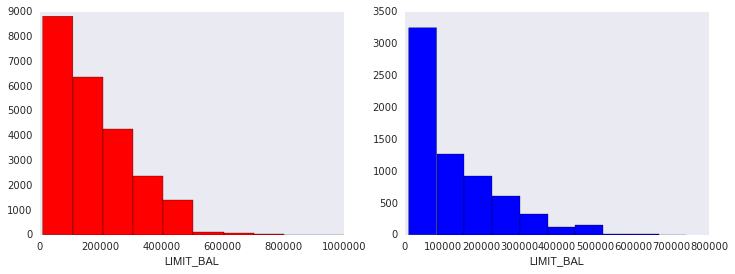

In [105]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(df0.LIMIT_BAL, color = 'r')
pylab.xlabel('LIMIT_BAL')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(df1.LIMIT_BAL, color = 'b')
pylab.xlabel('LIMIT_BAL')

pylab.show()

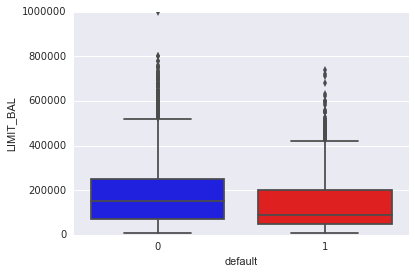

In [106]:
sns.boxplot(data=df, y="LIMIT_BAL", x="default", palette=["blue", "red"])

Оценим 95% доверительные интервалы для медиан двух выборок

In [107]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [109]:
df0Scores = list(map(np.median, get_bootstrap_samples(df0["LIMIT_BAL"].values, 1000)))
df1Scores = list(map(np.median, get_bootstrap_samples(df1["LIMIT_BAL"].values, 1000)))

print("default == 0: 95%% confidence interval for the median: ", stat_intervals(df0Scores))
print("default == 1: 95%% confidence interval for the median: ", stat_intervals(df1Scores))

default == 0: 95%% confidence interval for the median:  [ 150000.  150000.]
default == 1: 95%% confidence interval for the median:  [ 80000.  90000.]


Видно, что доверительные интервалы для медианы не пересекаются.

Для проверки гипотезы о равенстве распределений используем перестановочный критерий

In [110]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [111]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [112]:
np.random.seed(0)
print("p-value: %f" % permutation_test(df0.LIMIT_BAL, df1.LIMIT_BAL, max_permutations = 10000, alternative='greater'))

p-value: 0.000100


Уверенно можем отвергнуть нулевую гипотезу в пользу односторонней альтернативы.
С практической точки зрения это означает что есть определенная тенденция возвращать кредиты большей суммы.
## Гендер
Рассмотрим распределение каждой из выборок

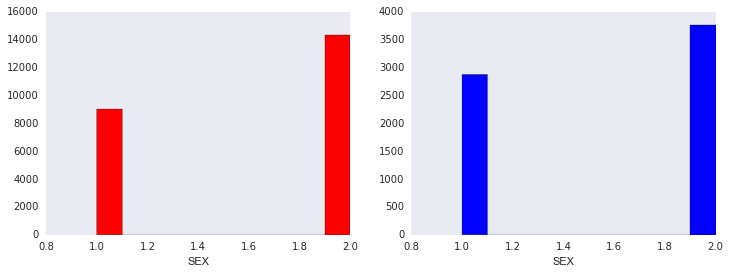

In [113]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(df0.SEX, color = 'r')
pylab.xlabel('SEX')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(df1.SEX, color = 'b')
pylab.xlabel('SEX')

pylab.show()

In [116]:
M0 = len(df0[df0.SEX==1])
M1 = len(df1[df1.SEX==1])

print("Доверительные доли для мужчин в выборках")
print("default==0 (95%%): [%f, %f]" % proportion_confint(M0, len(df0), method = 'wilson'))
print("default==1 (95%%): [%f, %f]" % proportion_confint(M1, len(df1), method = 'wilson'))

Доверительные доли для мужчин в выборках
default==0 (95%): [0.379627, 0.392110]
default==1 (95%): [0.421062, 0.444898]


Заметно, что доверительные интервалы не пересекаются. Очевидно, что имеются различия в гендерной структуре вернувших и невернувших кредит клиентов.

In [117]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = sc.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sc.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sc.stats.norm.cdf(z_stat)

доверительный интервал для разницы двух долей

In [120]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(df0.SEX-1, df1.SEX-1))

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


In [121]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(df0.SEX-1, df1.SEX-1), 'greater'))

p-value: 0.000000


Уверенно отвергаем нулевую гипотезу о равенстве долей женщин в выборке против односторонней альтернативы. С практической точки зрения это означает что женщины в целом более склонны к возврату кредита.
## Образование
Рассмотрим распределение уровня образования каждой из выборок

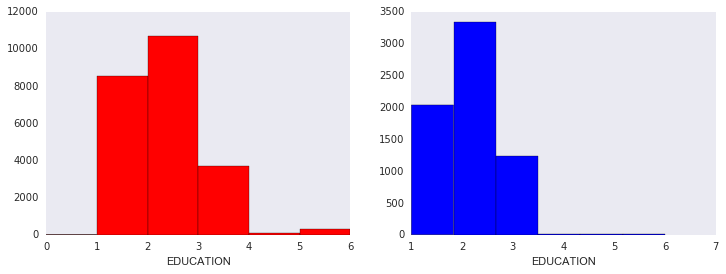

In [69]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(df0.EDUCATION, color = 'r', bins = 6)
pylab.xlabel('EDUCATION')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(df1.EDUCATION, color = 'b', bins = 6)
pylab.xlabel('EDUCATION')

pylab.show()

In [136]:
educs = list(set(df.EDUCATION.values))
pairs = [(educs[i], educs[j]) for i in range(len(educs)-1) for j in range(i+1,len(educs))]

pt = df.pivot_table(index="EDUCATION", 
     values="SEX", columns="default", aggfunc = len, fill_value=0)

In [137]:
pt

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [142]:
print('Кол-во измерений в совокупной выборке:', np.sum(np.array(pt)))
print('Доля элементов меньше 5:', np.sum(np.array(pt) < 5) / (pt.shape[0] * pt.shape[1]) )

Кол-во измерений в совокупной выборке: 30000
Доля элементов меньше 5: 0.0714285714286


Условия применимости критерия хи-квадрат выполняеются. Используем статистику хи-квадрат к таблице сопряженности уровня образования и индикатора возврата/невозврата

In [143]:
sc.stats.chi2_contingency(pt)[1]

1.2332626245415605e-32

По значению p-value видно что уровень образования никак не коррелирует с индикатором возврата/невозврата

В качестве визуального представления можно предложить график, показывающий разницу в ожидаемых и наблюдаемых значениях количества человек, вернувших и не вернувших кредит 

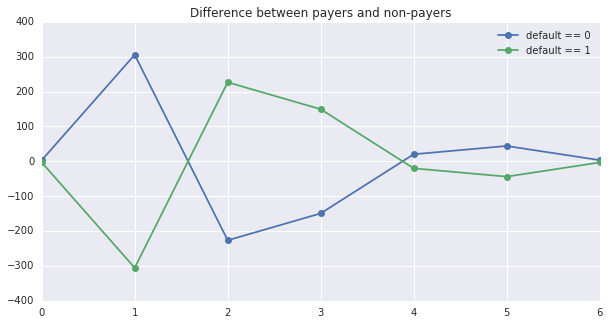

In [153]:
expected = sc.stats.chi2_contingency(pt.T)[3]

pylab.figure(figsize = (10,5))

pylab.plot(pt.ix[:,0].values - expected[0], 'o-')
pylab.plot(pt.ix[:,1].values - expected[1], 'o-')

pylab.legend(['default == 0','default == 1'])
pylab.title('Difference between payers and non-payers')

pylab.show()

Рассчитаем долю невозвратов кредита для каждой из категорий образования

In [160]:
(pt.T / pt.T.sum()).ix[1,:].T

EDUCATION
0    0.000000
1    0.192348
2    0.237349
3    0.251576
4    0.056911
5    0.064286
6    0.156863
Name: 1, dtype: float64

Доктора наук с наибольшей вероятностью вернут кредит, и аналогично выпускники школы, бакалавры и магистры со значительной долей вероятности не вернут кредит. Однако практической значимости не видно.

## Семейное положение

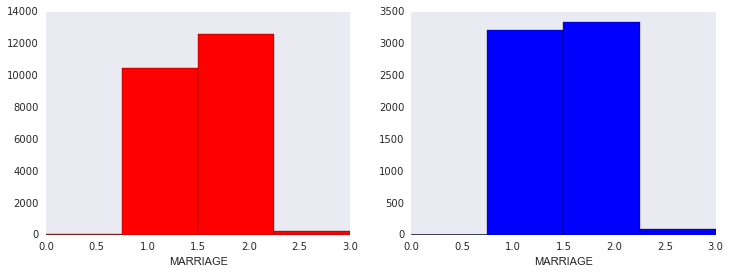

In [161]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(df0.MARRIAGE, color = 'r', bins = 4)
pylab.xlabel('MARRIAGE')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(df1.MARRIAGE, color = 'b', bins = 4)
pylab.xlabel('MARRIAGE')

pylab.show()

In [164]:
mars = list(set(df.MARRIAGE.values))
pairs = [(mars[i], mars[j]) for i in range(len(mars)-1) for j in range(i+1,len(mars))]

pt1 = df.pivot_table(index="MARRIAGE", 
     values="SEX", columns="default", aggfunc = len, fill_value=0)
pt1

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [162]:
print('Кол-во измерений в совокупной выборке:', np.sum(np.array(pt1)))
print('Доля элементов меньше 5:', np.sum(np.array(pt1) < 5) / (pt1.shape[0] * pt1.shape[1]) )

Кол-во измерений в совокупной выборке: 30000
Доля элементов меньше 5: 0.0


Условия применимости критерия хи-квадрат выполняеются. Используем статистику хи-квадрат к таблице сопряженности семейного положения и индикатора возврата/невозврата

In [167]:
chi2, p, dof, exp = sc.stats.chi2_contingency(pt1)

n = pt1.sum(axis = 1).sum()
cr_v = (chi2 / n) ** 0.5

In [168]:
print('Cramer\'s V = %.4f' % cr_v)
print('p-value = ', p)

Cramer's V = 0.0345
p-value =  8.82586245758e-08


По значению p-value отвергаем нулевую гипотезу. Исходя из значения коэффициента Крамера корреляция не очень значительна.

## Возраст
Рассмотрим распределение возвраста каждой из выборок

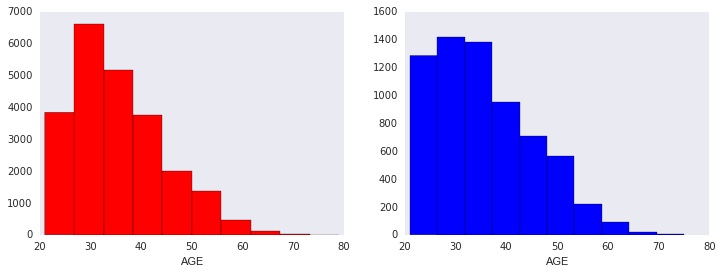

In [95]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(df0.AGE, color = 'r')
pylab.xlabel('AGE')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(df1.AGE, color = 'b')
pylab.xlabel('AGE')

pylab.show()

In [170]:
print("Тест Шапиро-Уилка для default == 0, W = %f, p = %f" % sc.stats.shapiro(df0.AGE))
print("Тест Шапиро-Уилка для default == 1, W = %f, p = %f" % sc.stats.shapiro(df1.AGE))

Тест Шапиро-Уилка для default == 0, W = 0.949614, p = 0.000000
Тест Шапиро-Уилка для default == 1, W = 0.950164, p = 0.000000


C:\Users\Dima\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1329: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


По результатам теста Шапиро-Уилка видимо что распределения не похожи на нормальные.

In [171]:
np.random.seed(0)

mar0 = list(map(np.median, get_bootstrap_samples(df0.AGE.values, 1000)))
mar1 = list(map(np.median, get_bootstrap_samples(df1.AGE.values, 1000)))

In [172]:
print("доверительный интервал для медианы возраста для default == 0:",  stat_intervals(mar0, 0.05))
print("доверительный интервал для медианы возраста для default == 1:",  stat_intervals(mar1, 0.05))

доверительный интервал для медианы возраста для default == 0: [ 34.  34.]
доверительный интервал для медианы возраста для default == 1: [ 34.  35.]


Видно что доверительные интервалы имеют пересечение. Построим доверительный интервал для разности медиан.

In [174]:
age_median_delta = np.array(mar0) - np.array(mar1)

print("доверительный интервал для разности медиан возрастов клиентов, вернувших и не вернувших кредит:",
stat_intervals(age_median_delta, 0.05))

доверительный интервал для разности медиан возрастов клиентов, вернувших и не вернувших кредит: [-1.  0.]


Видим, что доверительный интервал содержит ноль, отсюда можно предположить что медианы значимо не отличаются. Поскольку не выполняется предположение о нормальности распределений выборок и наши выборки несвязанные, можно попробовать применить к ним критерий Манна-Уитни.

In [178]:
def tiecorrect(rankvals):
    arr = np.sort(rankvals)
    idx = np.nonzero(np.r_[True, arr[1:] != arr[:-1], True])[0]
    cnt = np.diff(idx).astype(np.float64)
    size = np.float64(arr.size)
    return 1.0 if size < 2 else 1.0 - (cnt**3 - cnt).sum() / (size**3 - size)

x = df0.AGE.values
y = df1.AGE.values
n1 = len(x)
n2 = len(y)
ranked = sc.stats.rankdata(np.concatenate((x, y)))
rankx = ranked[0:n1]  # get the x-ranks
u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
u2 = n1*n2 - u1  # remainder is U for y
T = tiecorrect(ranked)
if T == 0:    
    raise ValueError('All numbers are identical in amannwhitneyu')
sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)
meanrank = n1*n2/2.0 + 0.5 
bigu = max(u1, u2)
z = np.abs(bigu - meanrank)
fact2 = 2.
z = z / sd
p_val = sc.stats.norm.sf(z) * fact2
print(p_val)

0.37250354349


Значение p-value довольно большое и не позволяет нам отклонить нулевую гипотезу о равенстве средних.

Практическая значимость заключается в возможности исключить возраст из модели скоринга что может упростить модель.